First of all, you construct the matrix of Gaussian basis, M, and you calculate the response vector R, as the product of the spectrum of interest with the matrix M:
 
$R = M^{T}s$
 
Then after computing the factorization via NNMF, you can calculate the weights as follow:
 
$v = (M^{T}H)^{-1}R$ 

And then reconstruct the spectrum with the following sum:
 
$\hat{s} \approx  Hv \approx  \sum_{i=1}^{k} v_{i}h_{i}$


 


明白，那么对于这个问题，你可以按照以下步骤使用NNMF来重建光谱：

构建高斯基矩阵M，其中每一行是一个高斯函数，覆盖了你感兴趣的波长范围。你可以使用之前提供的mu和sigma来构建高斯函数。高斯基矩阵M的维度是(471, k)，其中k是你选择的高斯函数数量。

计算响应向量R，它是将感兴趣的光谱数据s与高斯基矩阵M相乘得到的。具体来说，$R = M^{T}s$，R的维度是(k, 1494)。

使用NMF对响应向量R进行因式分解，得到两个因子矩阵W和H，使得$R \approx WH$。其中W的维度是(k, n)，n是你选择的因子数量；H的维度是(n, 1494)。

计算权重向量v，它是重建光谱的关键。根据上面的公式，$v = (M^{T}H)^{-1}R$。v的维度是(k, 1494)。

使用权重向量v和因子矩阵H重建光谱。具体来说，$\hat{s} \approx Hv \approx \sum_{i=1}^{k} v_{i}h_{i}$。其中$\hat{s}$的维度是(471, 1494)。

注意，这里的重建光谱$\hat{s}$可能会包含一些负值，你需要将它们裁剪为零。

实现以上步骤后，你就可以使用NNMF方法来重建你的光谱数据了。

In [99]:
import numpy as np
from sklearn.decomposition import NMF
from numpy.linalg import inv
import matplotlib.pyplot as plt
import os

In [122]:
class SPDReNMF:
    def __init__(self,spd_data):
        self.data = np.clip(spd_data, 0, None)
        self.wavelengths = np.arange(360, 831)
        self.mu = np.array([415, 445, 480, 515, 555, 590, 630, 680])
        self.sigma = np.array([11.0403, 12.7388, 15.2866, 16.5605, 16.5605, 16.9851, 21.2314, 22.0807])
        

    def gaussian_filter(self):
        filters = np.zeros((len(self.mu), len(self.wavelengths)))
        for i in range(len(self.mu)):
            filters[i] = np.exp(-0.5 * ((self.wavelengths - self.mu[i]) / self.sigma[i])**2)
        self.M = filters
    
    def compute_R(self):
        self.R = np.dot(self.M, self.data)
    
    def compute_H(self):
        nmf = NMF(n_components=8) 
        scores = nmf.fit_transform(self.data) 
        self.H = scores.T
    
    def compute_V(self):
        self.MH_inv = np.linalg.inv(np.dot(self.M, self.H.T))
        self.V = np.dot(self.MH_inv,self.R)

    def Reconstructed_spectrum(self):
        self.reconstructed_spectrum = np.dot(self.H.T, self.V)
        
    
    def Evaluate(self, Light, save_path=None):
        s = self.data[:, Light]
        s_re = self.reconstructed_spectrum[:, Light]
        MAE = np.mean(np.absolute(s - s_re))
        RMSE = np.sqrt(np.mean(np.square(s - s_re)))
        RRMSE = RMSE / np.mean(s_re)

        # GFC
        num = abs(np.sum(s * s_re))
        denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
        denom_s_re = np.sqrt(np.sum(s_re ** 2) + 1e-9)
        GFC = num / (denom_s * denom_s_re)

        print("MAE: ", MAE)
        print("RMSE: ", RMSE)
        print("RRMES: ", RRMSE)
        print("GFC: ", GFC)

        if save_path:
            with open(save_path, 'a') as f:
                f.write(f"Light: {Light + 1}\n")
                f.write(f"MAE: {MAE}\n")
                f.write(f"RMSE: {RMSE}\n")
                f.write(f"RRMES: {RRMSE}\n")
                f.write(f"GFC: {GFC}\n\n")
            print(f"Results saved to {save_path}")

    def Plot(self, Light, save_path=None):
        # 创建一个包含三个子图的图像
        fig, axs = plt.subplots(3, 1)
        s = self.data[:, Light]
        r = self.reconstructed_spectrum[:, Light]

        # 绘制真实光谱图
        axs[0].plot(self.wavelengths, s, label='True Spectrum')
        axs[0].set_xlabel('Wavelength (nm)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
        axs[0].legend()

        # 绘制重建光谱图
        axs[1].plot(self.wavelengths, r, label='Reconstructed Spectrum')
        axs[1].set_xlabel('Wavelength (nm)')
        axs[1].set_ylabel('Intensity')
        axs[1].legend()

        # 绘制重建光谱和真实光谱叠加的图
        axs[2].plot(self.wavelengths, s, label='True Spectrum')
        axs[2].plot(self.wavelengths, r, label='Reconstructed Spectrum')
        axs[2].set_xlabel('Wavelength (nm)')
        axs[2].set_ylabel('Intensity')
        axs[2].legend()

        if save_path:
            file_name = f"Light_s{Light + 1}.png"
            plt.savefig(os.path.join(save_path, file_name))

        plt.tight_layout()
        plt.show()
        

In [113]:
spd = np.load("/Users/dongtianchi/Documents/GIT/SpectralReconstruction/ComputationalSpectrometers/NNLS/cleandata.npy", allow_pickle= True)

In [123]:
r = SPDReNMF(spd)

In [124]:
r.gaussian_filter()
r.compute_R()
r.compute_H()
r.compute_V()
r.Reconstructed_spectrum()
print("M: ", r.M.shape)
print("R: ", r.R.shape)
print("H: ", r.H.shape)
print("V: ", r.V.shape)
print("s: ", r.reconstructed_spectrum.shape)

M:  (8, 471)
R:  (8, 1494)
H:  (8, 471)
V:  (8, 1494)
s:  (471, 1494)


/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [125]:
with open('output_NMF/results.txt', 'w') as f:
    f.write('')

In [126]:
Light_list = [0,3,300,1000,1493] 

for i in Light_list:
    r.Evaluate(i, "output_NMF/results.txt")

MAE:  0.0005531035769665298
RMSE:  0.000956555542917616
RRMES:  0.1565451085934982
GFC:  0.9965939585838599
Results saved to output_NMF/results.txt
MAE:  0.0015866238040191754
RMSE:  0.0036049749702724058
RRMES:  0.5284931234330532
GFC:  0.970061090887947
Results saved to output_NMF/results.txt
MAE:  0.0004956847354960105
RMSE:  0.0006599219399682167
RRMES:  0.09816733833744398
GFC:  0.9976352589705105
Results saved to output_NMF/results.txt
MAE:  0.0003670288287581739
RMSE:  0.0006657744654123058
RRMES:  0.08989986793932224
GFC:  0.9976257097709783
Results saved to output_NMF/results.txt
MAE:  0.00080504578522504
RMSE:  0.0022001191047591687
RRMES:  0.22424904848609417
GFC:  0.9931761137690293
Results saved to output_NMF/results.txt


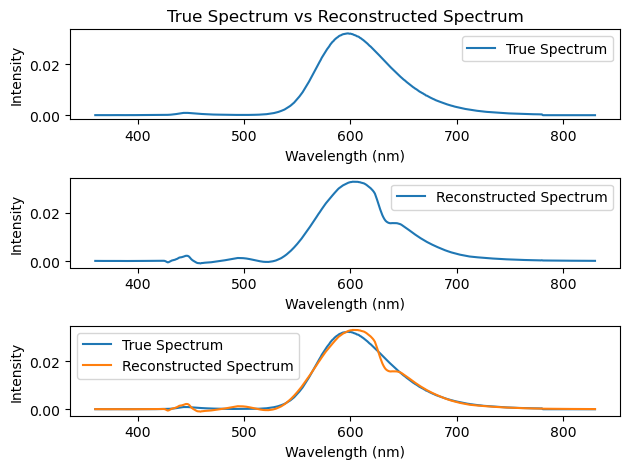

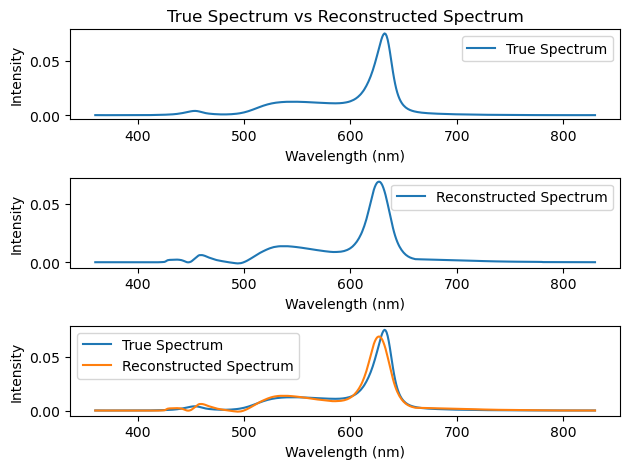

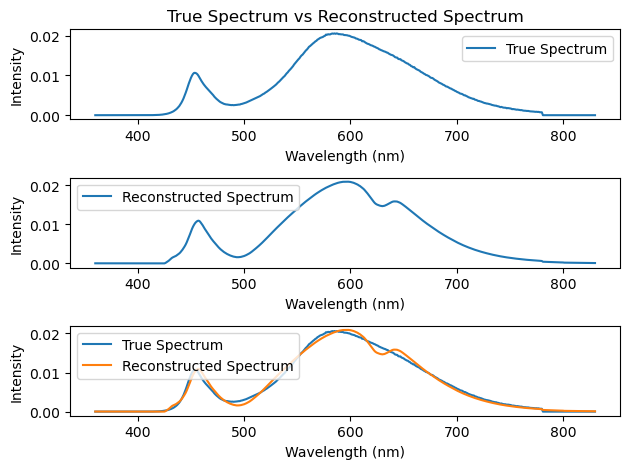

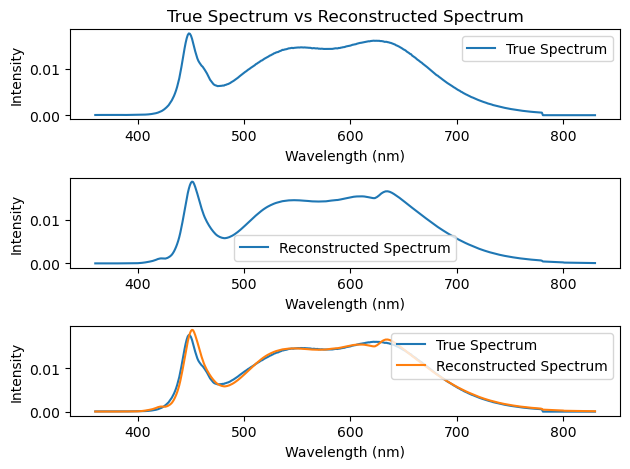

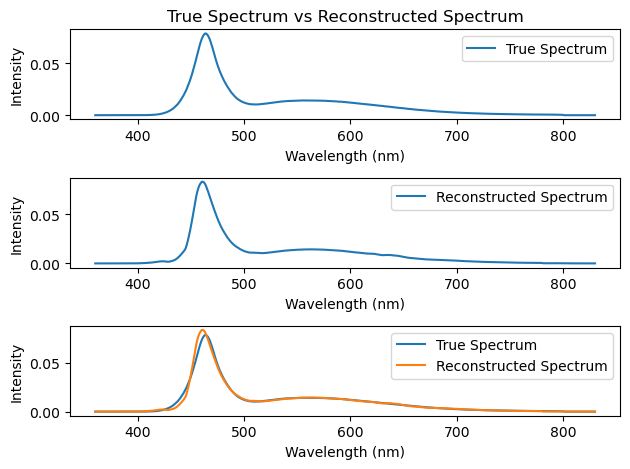

In [127]:
for i in Light_list:
    r.Plot(i, "output_NMF")